#### 2.2. Fundamental Analysis (Text mining):

#### 2.2-1. Explanatory Data Analysis

In [46]:
df_fund = df = pd.read_csv('Fundamental Analysis.txt',sep='\t')
df_fund.drop(['Unnamed: 0','CONTENT','DATE','TITLE'],axis=1,inplace = True)

In [47]:
# create new feature of word count and avg length of word for explanatory variable analysis
df_fund['word_count'] = df_fund['ALL_CONTENT'].apply(lambda x: len(str(x).split(" ")))
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df_fund['avg_word'] = df_fund['ALL_CONTENT'].apply(lambda x: avg_word(x))

In [48]:
df_fund.shape

(7767, 14)

In [49]:
sum(df_fund['avg_word'])/len(df_fund['avg_word'])

5.202130023837429

In [50]:
df_fund = df_fund[['Date','ALL_CONTENT','CATEGORIES','Direction','Px change %','word_count','avg_word']]
df_fund.head()

,Date,ALL_CONTENT,CATEGORIES,Direction,Px change %,word_count,avg_word
0,03/04/2019,"Apple AirPods Review: Perfect Earbuds, but The...",Personal Tech,1,0.006855,28,5.892857
1,26/03/2019,Apple Unveils Video Service With Celebrity Par...,Technology,0,-0.010332,28,5.607143
2,26/03/2019,Samsung Predicts Disappointing Results as Chip...,Business,0,-0.010332,24,5.875000
3,17/04/2019,Apple and Qualcomm Settle All Disputes Worldwi...,Technology,1,0.019473,21,5.666667
4,10/04/2019,Organizing Your Unwieldy Photo Collection Is E...,Personal Tech,1,0.005614,20,5.000000


Number of news articles by categories

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

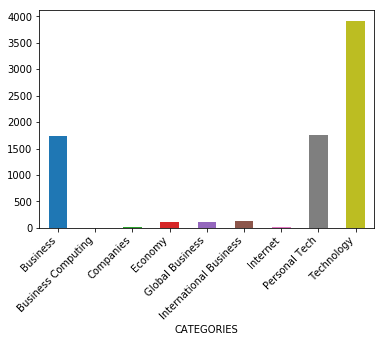

In [51]:
counts_category = df_fund.groupby('CATEGORIES').count().iloc[:,1]
counts_category.plot.bar()
plt.xticks(rotation=45, ha='right')

Number of news articles by direction

(array([0, 1]), <a list of 2 Text xticklabel objects>)

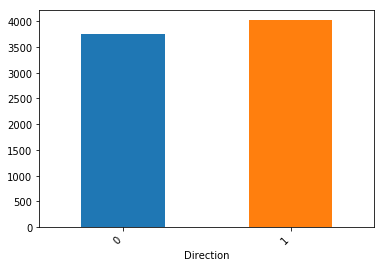

In [52]:
counts_category = df_fund.groupby('Direction').count().iloc[:,1]
counts_category.plot.bar()
plt.xticks(rotation=45, ha='right')

Percentage price change by classes (0 or 1) in boxplot

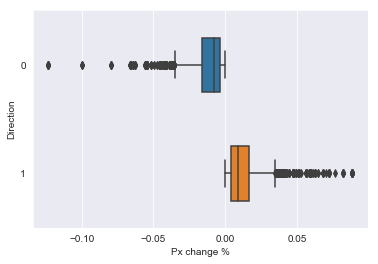

In [24]:
sns.set_style("darkgrid")
sns.boxplot(x="Px change %",y="Direction",orient='h',width=0.5,data=df_fund)

Word counts by classes by boxplot

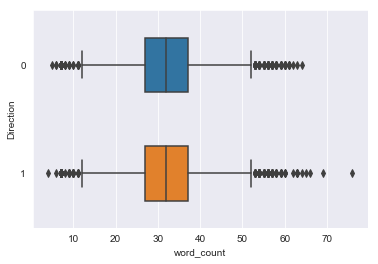

In [25]:
sns.set_style("darkgrid")
sns.boxplot(x="word_count",y="Direction",orient='h',width=0.5,data=df_fund)

Histogram of average length of words and word count

C:\Users\Natalie Kim\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


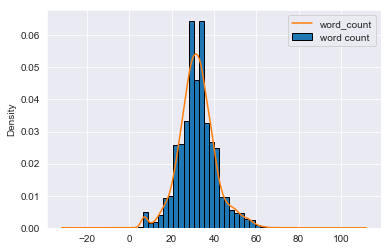

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
df_fund['word_count'].hist(bins=30,ax=ax, edgecolor='k',normed=1,label="word count")
df_fund['word_count'].plot(kind='kde',ax=ax)
#ax.set_xlim([-0.1,0.1])
ax.legend()

C:\Users\Natalie Kim\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


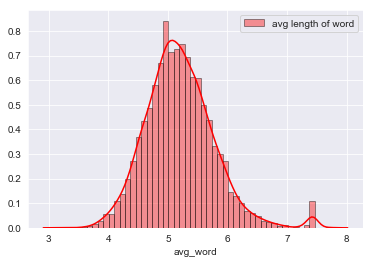

In [27]:
f, ax = plt.subplots(1, 1)
#sns.distplot( df_fund['word_count'] , color="skyblue", hist_kws=dict(edgecolor='k',linewidth=1), label="word count")
sns.distplot(df_fund['avg_word'] , color="red", hist_kws=dict(edgecolor='k',linewidth=1),label="avg length of word")
ax.legend()

#### 2.2-2. Feature extraction from text

#### Step1: Text pre-processing

Text normalization is performed on obtained data. Pre-processing includes: lower casing, removing punctuation and stop words (words without useful information), and lemmatization with pos tag.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.stem import WordNetLemmatizer 
import string
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import wordnet


In [54]:
#Below lemmatization pos tag code referenced from:
#***************************************************************************************
#*    Title: Lemmatization Approaches with Examples in Python
#*    Author: Machine Learning Plus
#*    Date: 23 October 2018
#*    Code version: N/A
#*    Availability:https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
#*
#***************************************************************************************/
def get_wordnet_pos(word):
    """POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [55]:
def preprocess(docs):
    """
    preprocess each document by tokenizing, removing stopwords, and stemming
    """
    # initialize regex tokenizer and porter stemmer, get english stopwords
    exclude = set(string.punctuation+'0123456789'+'…')
    tokenizer = RegexpTokenizer(r'\w+')
    english_sw = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    preprocessed = []
    for doc in docs:
        # lowercase each texts in document and remove puntuation and numbers
        raw = doc.lower()
        raw = ''.join([ch for ch in raw if ch not in exclude])
        # tokenize document with regrex tokenizer
        tokens = tokenizer.tokenize(raw)
        # remove stop words
        clean_tokens = [i for i in tokens if i not in english_sw]
        # stemming tokens
        #stemmed = [stemmer.stem(i) for i in clean_tokens]
        #Lemmatization with pos tag
        lemma = [lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in clean_tokens]

        # add tokens to list
        preprocessed.append(lemma)
    return preprocessed

In [56]:
documents = df_fund.iloc[:,1].tolist() 
# pre-process each documents (each ads) and de-tokenize
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
clean_documents = preprocess(documents)
clean_documents = [' '.join(doc) for doc in clean_documents]
clean_documents[10]

'week tech much regulation much know far go curb big tech power might straightforward first seem'

#### Step 2: Feature Extraction by term-document frequency matrix and TF-IDF

Before we proceed with feature extraction step, one more step to be done for pre-processing. As most frequent and least frequent words will not convey significant meaning for our text data, we will remove them. First we identify those words:

In [64]:
#process the entire document
def tdm_count(docs,n_gram):
    exclude = set(string.punctuation+'0123456789'+'…')
    First = 1
    for txt in docs:
        if txt != "":
            vectorizer = CountVectorizer(stop_words='english',ngram_range=(n_gram,n_gram))
            vec = vectorizer.fit_transform([txt])
            word_dict = dict((x,y) for x,y in zip(vectorizer.get_feature_names(),vec.toarray().tolist()[0]))
            if First == 1:
                tdm_count = Counter(word_dict)
                First = 0
            else:
                tdm_count = tdm_count + Counter(word_dict)
    return tdm_count

In [58]:
tdm_count_news = tdm_count(clean_documents,1)

Extract 10 most and least frequent words

In [59]:
#Most frequent
tdm_count= sorted(tdm_count_news.items(), key=lambda x: x[1], reverse=True)
#top 10 appeared words
freq = tdm_count[:10]
freq

[('apple', 3242),
 ('new', 1943),
 ('company', 1681),
 ('google', 1073),
 ('say', 1026),
 ('iphone', 1016),
 ('report', 766),
 ('tech', 760),
 ('make', 756),
 ('phone', 696)]

In [61]:
#Least frequent
tdm_count= sorted(tdm_count_news.items(), key=lambda x: x[1], reverse=True)
#top 10 appeared words
not_freq = tdm_count[-10:]
not_freq

[('donottrack', 1),
 ('runnerups', 1),
 ('hid', 1),
 ('wirelessnetwork', 1),
 ('overload', 1),
 ('streetview', 1),
 ('refugee', 1),
 ('invisibility', 1),
 ('karlsruhe', 1),
 ('piracyproof', 1)]

Some visualizations..

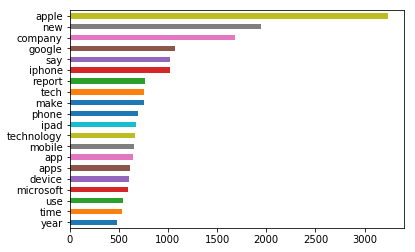

In [62]:
#horizontal barplot using pandas
tdm_count_dict = dict(tdm_count)
tdm_count_dict = pd.Series(tdm_count_dict,index=tdm_count_dict.keys())
tdm_count_dict.iloc[:20].sort_values(ascending=True).plot(kind='barh')

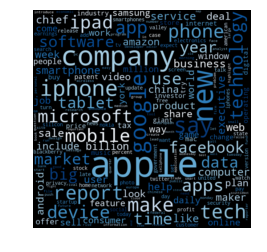

In [63]:
#number of words
wordcloud = WordCloud(width=600, height=600, max_words=200, max_font_size=100, colormap='Blues').generate_from_frequencies(tdm_count_news)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [65]:
tdm_count_news_2 = tdm_count(clean_documents,2)

In [66]:
#sort by count
tdm_count_2= sorted(tdm_count_news_2.items(), key=lambda x: x[1], reverse=True)
#top 10 appeared words
tdm_count_2[:10]

[('daily report', 285),
 ('new york', 282),
 ('chief executive', 243),
 ('york time', 208),
 ('silicon valley', 189),
 ('united state', 170),
 ('today scuttlebot', 128),
 ('tech company', 121),
 ('technology reporter', 107),
 ('steve job', 105)]

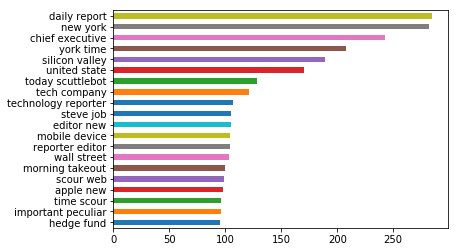

In [67]:
#horizontal barplot using pandas
tdm_count_dict_2 = dict(tdm_count_2)
tdm_count_dict_2 = pd.Series(tdm_count_dict_2,index=tdm_count_dict_2.keys())
tdm_count_dict_2.iloc[:20].sort_values(ascending=True).plot(kind='barh')

Now remove above 20 words from our data:

In [68]:
# words to be excluded
freq = [each[0] for each in freq]
not_freq = [each[0] for each in not_freq]
exclude = freq+not_freq
exclude

['apple',
 'new',
 'company',
 'google',
 'say',
 'iphone',
 'report',
 'tech',
 'make',
 'phone',
 'donottrack',
 'runnerups',
 'hid',
 'wirelessnetwork',
 'overload',
 'streetview',
 'refugee',
 'invisibility',
 'karlsruhe',
 'piracyproof']

In [69]:
documents = df_fund.iloc[:,1].tolist() 
new_clean_documents = preprocess(documents)

In [70]:
new_doc = [" ".join(word for word in x if word not in exclude) for x in new_clean_documents] 
new_doc[1]

'unveils video service celebrity parade detail maker partner hollywood heavyweight publisher provide broad service user'

#### Term-document Frequency Matrix 

Uni-gram (one word) with max_features = 1000

In [71]:
# term - document matrix
count_vector = CountVectorizer(stop_words='english',max_features = 1000)
X_train_counts = count_vector.fit_transform(new_doc)
tdm = pd.DataFrame(X_train_counts.toarray(), columns=[count_vector.get_feature_names()])
tdm.head()

,ability,able,access,accessory,accord,account,accuse,ackman,acquire,acquisition,...,worry,worth,write,writes,yahoo,year,york,young,youtube,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Bi-gram (Two word)

In [72]:
# term - document matrix
count_vector = CountVectorizer(stop_words='english',ngram_range=(2,2),max_features = 1000)
X_train_counts_2 = count_vector.fit_transform(new_doc)
tdm = pd.DataFrame(X_train_counts_2.toarray(), columns=[count_vector.get_feature_names()])
tdm.head()

,access data,accord people,activist hedge,activist investor,ad blocker,add feature,address book,adobe flash,afterhours trading,agree buy,...,worth trillion,writes deal,xi jinping,year ago,year earlier,york city,york stock,york time,youtube video,zuckerberg facebook
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### TF-IDF

Uni-gram

In [73]:
# create term-document matrix using TF-IDF. Arbitrary used L1 Norm used to normalize term vectors
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(norm=u'l2')
X_train_tfidf = tf_transformer.fit_transform(X_train_counts)
pd.DataFrame(X_train_tfidf.toarray(), columns=[count_vector.get_feature_names()]).head()

,access data,accord people,activist hedge,activist investor,ad blocker,add feature,address book,adobe flash,afterhours trading,agree buy,...,worth trillion,writes deal,xi jinping,year ago,year earlier,york city,york stock,york time,youtube video,zuckerberg facebook
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Bi-Gram

In [74]:
tf_transformer = TfidfTransformer(norm=u'l2')
X_train_tfidf_2 = tf_transformer.fit_transform(X_train_counts_2)
X_train_tfidf_2_pd = pd.DataFrame(X_train_tfidf_2.toarray(), columns=[count_vector.get_feature_names()])
X_train_tfidf_2_pd.head()

,access data,accord people,activist hedge,activist investor,ad blocker,add feature,address book,adobe flash,afterhours trading,agree buy,...,worth trillion,writes deal,xi jinping,year ago,year earlier,york city,york stock,york time,youtube video,zuckerberg facebook
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2.2-3. Topic Modeling and Dimensionality reduction

In [75]:
list(set(df_fund['CATEGORIES']))

['Internet',
 'Business Computing',
 'Economy',
 'Technology',
 'Personal Tech',
 'Global Business',
 'International Business',
 'Business',
 'Companies']

As we have 9 categories included in our dataset, first we try with n_components = 9

In [77]:
#https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# SVD decomposition
svd_model = TruncatedSVD(n_components=9, algorithm='randomized', n_iter=100, random_state=122)
tfidf_lsa = svd_model.fit_transform(X_train_tfidf_2) 
tfidf_lsa = Normalizer(copy=False).fit_transform(tfidf_lsa)
len(svd_model.components_)

9

In [78]:
tfidf_lsa[0]

array([-0.02278965,  0.50841364,  0.19712167,  0.06394099,  0.81487111,
       -0.00357622, -0.17768798, -0.02856794, -0.04042209])

In [79]:
svd_model

TruncatedSVD(algorithm='randomized', n_components=9, n_iter=100,
       random_state=122, tol=0.0)

In [80]:
# get top 7 words in each topic 
terms = count_vector.get_feature_names()
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])

Topic 0: 
silicon valley
chief executive
york time
technology reporter
today scuttlebot
editor york
reporter editor
Topic 1: 
york time
technology reporter
editor york
reporter editor
today scuttlebot
scour web
time scour
Topic 2: 
morning takeout
takeout highlight
dealbook newsletter
highlight dealbook
takeout today
today morning
steve job
Topic 3: 
united state
chief executive
trade war
outside united
market share
economist writes
data center
Topic 4: 
chief executive
cook chief
tim cook
steve job
timothy cook
steven job
jc penney
Topic 5: 
mobile device
web site
smartphones tablet
social network
app developer
desktop computer
chip maker
Topic 6: 
steve job
steven job
wall street
mr job
san francisco
tim cook
job cofounder
Topic 7: 
wall street
goldman sachs
hedge fund
morning agenda
wall st
insider trading
technology sector
Topic 8: 
web site
app smart
smart extra
app store
mobile app
apps help
mobile apps


Dimensionality Reduction

In [81]:
# choose parameter = 9 as number of categories are 9
svd = TruncatedSVD(9)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
lsa_factors = lsa.fit_transform(X_train_tfidf_2)
pd.DataFrame(lsa_factors).head()

,0,1,2,3,4,5,6,7,8
0,0.066354,-0.108950,-0.080730,-0.002197,0.712783,-0.159019,-0.138820,0.187945,-0.623910
1,0.007412,-0.262527,-0.162170,-0.577409,-0.696642,-0.118315,0.152428,0.103387,-0.195173
2,0.034723,0.041387,0.006214,0.013423,0.046236,0.011508,0.084273,0.956333,-0.270034
3,-0.010241,0.105007,0.559315,0.699541,0.322043,0.227814,0.080731,0.130034,-0.087403
4,-0.035912,0.091688,0.013366,-0.232307,-0.049742,0.033557,0.401036,0.387044,-0.788622
